In [19]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [84]:
insurance_df = pd.read_csv('./data/health_insurance_coverage_2021.csv')
pcp_medicaid_df = pd.read_csv('./data/pcp_medicaid_2021.csv')
pcp_commercial_df = pd.read_csv('./data/pcp_commercial_2021.csv')

# Load the shapefile to create polygons and Filter out polygons where 'AWATER' is larger than 'ALAND'
tracts_gdf = gpd.read_file('./data/tl_2021_36_tract/tl_2021_36_tract.shp')
tracts_gdf = tracts_gdf[tracts_gdf['AWATER'] <= tracts_gdf['ALAND']]

In [98]:
# Convert the DataFrame into a GeoDataFrame for Medicaid
pcp_medicaid_gdf = gpd.GeoDataFrame(pcp_medicaid_df, geometry=gpd.points_from_xy(pcp_medicaid_df.Longitude, pcp_medicaid_df.Latitude))

# Convert the DataFrame into a GeoDataFrame for Commercial
pcp_commercial_gdf = gpd.GeoDataFrame(pcp_commercial_df, geometry=gpd.points_from_xy(pcp_commercial_df.Longitude, pcp_commercial_df.Latitude))

# Check the coordinate reference system (CRS) for each GeoDataFrame to ensure they match
pcp_medicaid_gdf.crs = 'EPSG:4326'
pcp_commercial_gdf.crs = 'EPSG:4326'
target_crs = 'EPSG:32016'
tracts_gdf = tracts_gdf.to_crs(target_crs)
pcp_medicaid_gdf = pcp_medicaid_gdf.to_crs(target_crs)
pcp_commercial_gdf = pcp_commercial_gdf.to_crs(target_crs)
print(pcp_medicaid_gdf.crs, pcp_commercial_gdf.crs, tracts_gdf.crs)

# Perform spatial join to count points in polygons
pcp_medicaid_join = gpd.sjoin(pcp_medicaid_gdf, tracts_gdf, how='inner', predicate='within')
pcp_commercial_join = gpd.sjoin(pcp_commercial_gdf, tracts_gdf, how='inner', predicate='within')

# Drop rows with NaN values in the geometry column (indicating points outside of tracts_gdf polygons)
pcp_medicaid_join = pcp_medicaid_join.dropna(subset=['geometry'])
pcp_commercial_join = pcp_commercial_join.dropna(subset=['geometry'])

# Group by polygon identifier and calculate the count of points within each polygon
pcp_medicaid_count = pcp_medicaid_join.groupby('GEOID').size().reset_index(name='pcp_medicaid_count')
pcp_commercial_count = pcp_commercial_join.groupby('GEOID').size().reset_index(name='pcp_commercial_count')

# Merge the point counts with the polygons GeoDataFrame
pcp_medicaid_tracts = tracts_gdf.merge(pcp_medicaid_count, on='GEOID', how='left')
pcp_commercial_tracts = tracts_gdf.merge(pcp_commercial_count, on='GEOID', how='left')

# Merge the medicaid with the polygons GeoDataFrame
pcp_medicaid_tracts['GEOID'] = pcp_medicaid_tracts['GEOID'].astype('int64')
pcp_commercial_tracts['GEOID'] = pcp_commercial_tracts['GEOID'].astype('int64')
pcp_medicaid_tracts = pcp_medicaid_tracts.merge(insurance_df[['GEOID', 'medicaid']], on='GEOID', how='left')
pcp_commercial_tracts = pcp_commercial_tracts.merge(insurance_df[['GEOID', 'commercial']], on='GEOID', how='left')

# Replace null values with 0 in the 'point_count' column of the final_result DataFrame
pcp_medicaid_tracts['pcp_medicaid_count'] = pcp_medicaid_tracts['pcp_medicaid_count'].fillna(0)
pcp_commercial_tracts['pcp_commercial_count'] = pcp_commercial_tracts['pcp_commercial_count'].fillna(0)

EPSG:32016 EPSG:32016 EPSG:32016


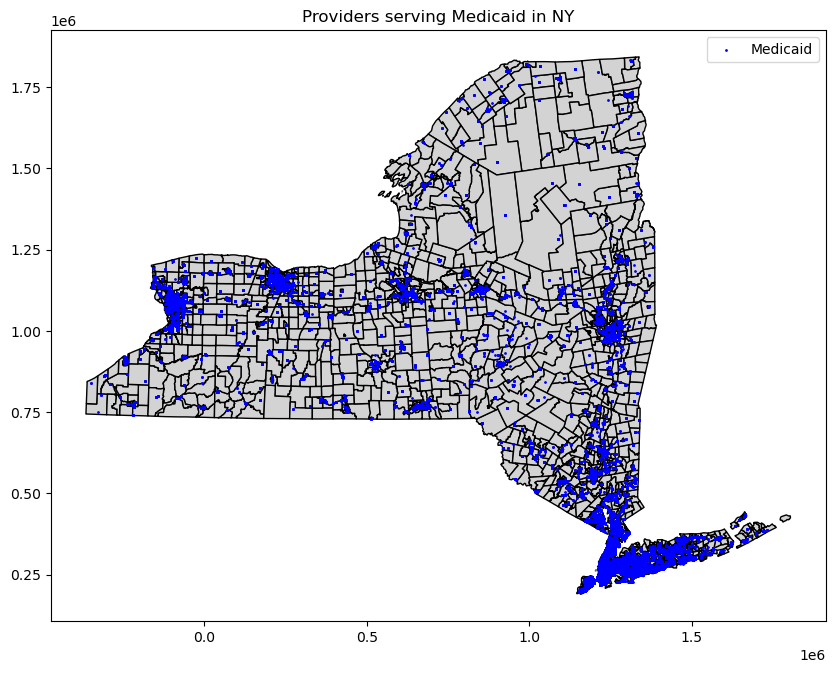

In [72]:
# Plot the census tracts
tracts_gdf.plot(color='lightgrey', edgecolor='black', figsize=(10, 12))

# Plot the Medicaid points
pcp_medicaid_join.plot(ax=plt.gca(), color='blue', markersize=1, label='Medicaid')

# Add legend
plt.legend()
plt.title('Providers serving Medicaid in NY')

# Show the plot
plt.show()

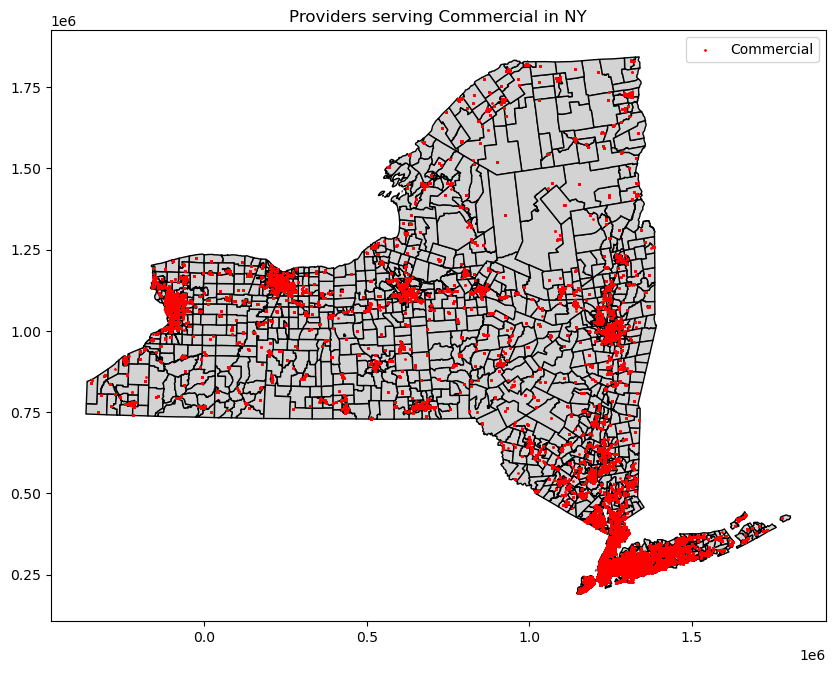

In [73]:
# Plot the census tracts
tracts_gdf.plot(color='lightgrey', edgecolor='black', figsize=(10, 12))

# Plot the Commercial points
pcp_commercial_join.plot(ax=plt.gca(), color='red', markersize=1, label='Commercial')

# Add legend
plt.legend()
plt.title('Providers serving Commercial in NY')

# Show the plot
plt.show()

In [100]:
# Export the final_result GeoDataFrame to a GeoJSON file
pcp_medicaid_tracts.to_file("pcp_medicaid_tracts.geojson", driver='GeoJSON')
pcp_commercial_tracts.to_file("pcp_commercial_tracts.geojson", driver='GeoJSON')

In [101]:
print(pcp_commercial_tracts.columns)

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'pcp_commercial_count', 'commercial'],
      dtype='object')
